In [3]:
import json
import warnings
from io import BytesIO
from pathlib import Path

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep.formula import value
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
import numpy as np
warnings.filterwarnings("ignore", category=pd.io.pytables.PerformanceWarning)
from mplsoccer import Pitch
from mplsoccer import VerticalPitch
from mplsoccer import Radar
from mplsoccer import FontManager
import matplotlib.pyplot as plt
import matplotsoccer
from ipywidgets import fixed, interact_manual, widgets
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

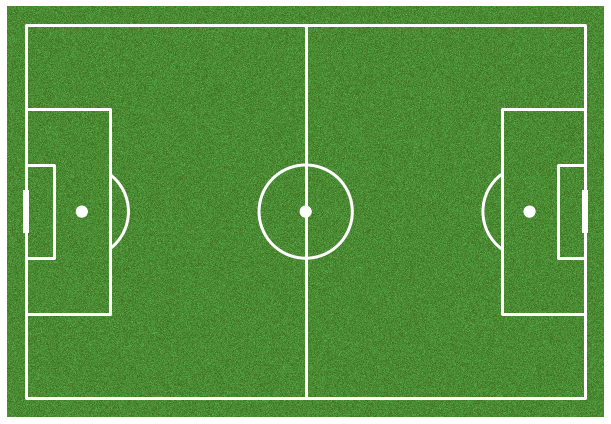

In [4]:
pitch = Pitch(pitch_type = "statsbomb",
              half = False, axis = False, label = False,
              pitch_color = "grass", line_color = "w",
              positional = False, shade_middle = False, positional_color = "dimgray", 
              linewidth = 3, spot_scale = 0.01, line_zorder = 2)

fig, ax = pitch.draw(figsize = (12, 6))

plt.show()

In [11]:
WYSCOUT_BASE_PATH = "../../wyscout"

In [12]:
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [13]:
json_teams = read_json_file(f"{WYSCOUT_BASE_PATH}/teams.json")

df_teams = pd.read_json(json_teams)

In [14]:
json_players = read_json_file(f"{WYSCOUT_BASE_PATH}/players.json")

df_players = pd.read_json(json_players)

In [15]:
competitions = [
#     "England",
#     "France",
#     "Germany",
    "Italy",
#    "Spain",
#    "European Championship",
#    "World Cup"
]

dfs_matches = list()

for competition in competitions:
    competition_name = competition.replace(" ", "_")
    file_matches = f"{WYSCOUT_BASE_PATH}/matches_{competition_name}.json"
    json_matches = read_json_file(file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)
    
df_matches = pd.concat(dfs_matches)

In [16]:
df_teams.to_hdf(f"{WYSCOUT_BASE_PATH}/wyscout.h5",
                key = "teams", mode = "w")

In [17]:
df_players.to_hdf(f"{WYSCOUT_BASE_PATH}/wyscout.h5",
                  key = "players", mode = "a")

In [18]:
df_matches.to_hdf(f"{WYSCOUT_BASE_PATH}/wyscout.h5",
                  key = "matches", mode = "a")

In [19]:
for competition in competitions:
    competition_name = competition.replace(" ", "_")
    file_events = f"{WYSCOUT_BASE_PATH}/events_{competition_name}.json"
    json_events = read_json_file(file_events)
    df_events = pd.read_json(json_events)
    df_events_matches = df_events.groupby("matchId", as_index = False)
    for match_id, df_events_match in df_events_matches:
        df_events_match.to_hdf(f"{WYSCOUT_BASE_PATH}/wyscout.h5",
                               key = f"events/match_{match_id}", mode = "a")

In [20]:
convert_to_spadl(f"{WYSCOUT_BASE_PATH}/wyscout.h5",
                 f"{WYSCOUT_BASE_PATH}/spadl.h5")

  0%|          | 0/380 [00:00<?, ?game/s]

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


  0%|          | 0/380 [00:00<?, ?game/s]

...Converting events to actions


100%|██████████| 380/380 [10:45<00:00,  1.70s/game]


---

In [21]:
spadl_path = f"{WYSCOUT_BASE_PATH}/spadl.h5"

In [22]:
df_teams = pd.read_hdf(spadl_path, key = "teams")
df_players = pd.read_hdf(spadl_path, key = "players")
df_games = pd.read_hdf(spadl_path, key = "games")

In [23]:
# from id to name
teams_mapping = df_teams.set_index("team_id")["team_name"].to_dict()

{k: teams_mapping[k] for k in list(teams_mapping.keys())[:2]}

{1613: 'Newcastle United FC', 692: 'Real Club Celta de Vigo'}

In [24]:
df_games["home_team_name"] = df_games["home_team_id"].map(teams_mapping)
df_games["away_team_name"] = df_games["away_team_id"].map(teams_mapping)

In [25]:
# juve crotone
game_id = 2576094

with pd.HDFStore(spadl_path) as file:
    df_actions = file[f"actions/game_{game_id}"]
    
    df_actions = (
        df_actions.merge(file["actiontypes"], how = "left")\
                  .merge(file["results"], how = "left")\
                  .merge(file["bodyparts"], how = "left")\
                  .merge(file["players"], how = "left")\
                  .merge(file["teams"], how = "left")\
                  .reset_index()\
                  .rename(columns = {"index": "action_id"}))

In [26]:
df_actions[:5]

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,type_name,result_name,bodypart_name,short_name,first_name,last_name,birth_date,short_team_name,team_name
0,0,2576094.0,1.0,0.502974,3197.0,99423.0,53.55,34.00,71.40,35.36,0,0,1,pass,success,foot,A. Tonev,Aleksandar,Tonev,1990-02-02,Crotone,FC Crotone
1,1,2576094.0,1.0,2.775406,3197.0,20815.0,71.40,35.36,77.70,46.24,0,0,1,pass,success,foot,A. Barberis,Andrea,Barberis,1993-12-11,Crotone,FC Crotone
2,2,2576094.0,1.0,4.769526,3197.0,21280.0,77.70,46.24,72.45,37.40,0,0,1,pass,success,foot,M. Sampirisi,Mario,Sampirisi,1992-10-31,Crotone,FC Crotone
3,3,2576094.0,1.0,5.852516,3197.0,20815.0,72.45,37.40,79.80,28.56,0,0,1,pass,success,foot,A. Barberis,Andrea,Barberis,1993-12-11,Crotone,FC Crotone
4,4,2576094.0,1.0,8.148092,3197.0,49857.0,79.80,28.56,77.70,19.04,0,0,1,pass,success,foot,A. Ajeti,Arlind,Ajeti,1993-09-25,Crotone,FC Crotone


In [27]:
def nice_time(row):
    minute = int((row["period_id"] >= 2) * 45 \
               + (row["period_id"] >= 3) * 15 \
               + (row["period_id"] == 4) * 15 \
               + row["time_seconds"] // 60)
    
    second = int(row["time_seconds"] % 60)
    return f"{minute}m{second}s"

def action_name(row):
    return f"{row['action_id']}: {row['nice_time']} - {row['short_name']} {row['type_name']}"

In [28]:
def plot_actions(df):
    matplotsoccer.actions(
        location    = df[["start_x", "start_y", "end_x", "end_y"]],
        action_type = df["type_name"],
        team        = df["team_name"],
        result      = df["result_name"] == "success",
        label       = df[["nice_time", "type_name", "short_name", "short_team_name"]],
        labeltitle  = ["time", "actiontype", "player", "team"],
        zoom        = False,
        figsize     = 8)


def plot_actions_from_action_name(df, action_name):
    action_id = int(action_name.split(":")[0])
    df = df[action_id - 3: action_id + 3]
    plot_actions(df)

In [29]:
df_actions["nice_time"] = df_actions.apply(nice_time, axis = 1)
df_actions["action_name"] = df_actions.apply(action_name, axis = 1)

In [30]:
interact_manual(plot_actions_from_action_name, 
                df = fixed(df_actions),
                action_name = widgets.Select(
                        options  = df_actions["action_name"][3:],
                        disabled = False)
               )

interactive(children=(Select(description='action_name', options=('3: 0m5s - A. Barberis pass', '4: 0m8s - A. A…

<function __main__.plot_actions_from_action_name(df, action_name)>

---

In [31]:
df_actions[(df_actions.type_name == "shot") &\
           (df_actions.result_name == "success")]

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,type_name,result_name,bodypart_name,short_name,first_name,last_name,birth_date,short_team_name,team_name,nice_time,action_name
894,894,2576094.0,2.0,381.537257,3159.0,14943.0,96.60,36.04,105.0,30.6,0,11,1,shot,success,foot,M. Mandžukić,Mario,Mandžukić,1986-01-14,Juventus,Juventus FC,51m21s,894: 51m21s - M. Mandžukić shot
1018,1018,2576094.0,2.0,846.642562,3159.0,20395.0,79.80,28.56,105.0,34.0,0,11,1,shot,success,foot,M. De Sciglio,Mattia,De Sciglio,1992-10-20,Juventus,Juventus FC,59m6s,1018: 59m6s - M. De Sciglio shot
1186,1186,2576094.0,2.0,1536.412446,3159.0,20579.0,101.85,37.40,105.0,37.4,0,11,1,shot,success,foot,M. Benatia,Medhi Amine,El Mouttaqi Benatia,1987-04-17,Juventus,Juventus FC,70m36s,1186: 70m36s - M. Benatia shot


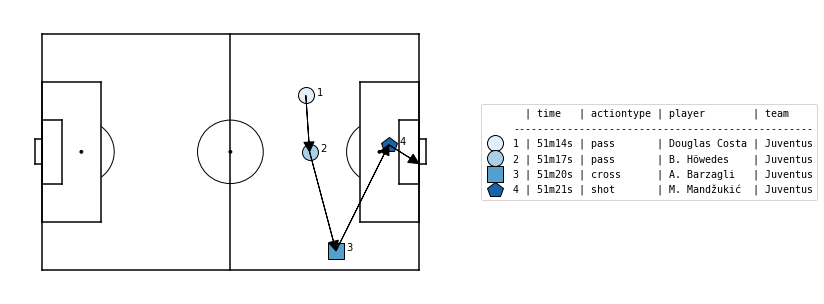

In [32]:
action_id = 894
plot_actions(df_actions[action_id - 3 : action_id + 1])

---

In [33]:
np.min(df_actions.start_x), np.max(df_actions.start_x)

(0.0, 105.0)

In [34]:
np.min(df_actions.start_y), np.max(df_actions.start_y)

(0.0, 68.0)

In [35]:
PITCH_LENGTH = 105
PITCH_WIDTH = 68

GOAL_X = PITCH_LENGTH
GOAL_Y = PITCH_WIDTH / 2

In [36]:
for side in ["start", "end"]:
    # normalize x and y
    df_actions[f"{side}_x_norm"] = df_actions[f"{side}_x"] / PITCH_LENGTH
    df_actions[f"{side}_y_norm"] = df_actions[f"{side}_y"] / PITCH_WIDTH
    
    # polar coords
    diff_x = GOAL_X - df_actions[f"{side}_x"]
    diff_y = np.abs(GOAL_Y - df_actions[f"{side}_y"])
    distance = np.sqrt(diff_x ** 2 + diff_y ** 2)
    angle = np.divide(diff_x, diff_y,
                      out = np.zeros_like(diff_x), where = (diff_y != 0))
    df_actions[f"{side}_distance_goal"] = distance
    df_actions[f"{side}_angle_goal"] = angle
    
    # locations: start/end in penalty box?
    box_condition = ((df_actions[f"{side}_x"] > (PITCH_LENGTH - 16.5)) &
                     (df_actions[f"{side}_y"] > (13.85)) &
                     (df_actions[f"{side}_y"] > (PITCH_WIDTH - 13.85)))
    
    df_actions[f"{side}_is_penalty_box"] = box_condition

In [37]:
df_actions["diff_x"] = df_actions["end_x"] - df_actions["start_x"]
df_actions["diff_y"] = df_actions["end_y"] - df_actions["start_y"]
df_actions["distance_covered"] = np.sqrt((df_actions["end_x"] - df_actions["start_x"]) ** 2 +
                                         (df_actions["end_y"] - df_actions["start_y"]) ** 2)

df_actions["time_played"] = (df_actions["time_seconds"] + \
                            (df_actions["period_id"] >= 2) * (45 * 60) + \
                            (df_actions["period_id"] >= 3) * (15 * 60) + \
                            (df_actions["period_id"] >= 4) * (15 * 60))

---

In [38]:
delays = 3
features_to_delay = ["game_id", "period_id", "time_seconds", "team_id",
                     "player_id", "start_x", "start_y", "end_x", "end_y",
                     "bodypart_id", "type_id", "result_id", "type_name",
                     "result_name", "bodypart_name", "time_played"]

In [39]:
def create_delayed_features(df, features_to_delay, delays):
    df_delays = [df[features_to_delay].shift(step).add_suffix(f'-{step}') for step in range(0, delays)]
    return pd.concat(df_delays, axis=1)

In [40]:
df_features = create_delayed_features(df_actions, features_to_delay, delays)

In [41]:
df_features.head()

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,type_id-0,result_id-0,type_name-0,result_name-0,bodypart_name-0,time_played-0,game_id-1,period_id-1,time_seconds-1,team_id-1,player_id-1,start_x-1,start_y-1,end_x-1,end_y-1,bodypart_id-1,type_id-1,result_id-1,type_name-1,result_name-1,bodypart_name-1,time_played-1,game_id-2,period_id-2,time_seconds-2,team_id-2,player_id-2,start_x-2,start_y-2,end_x-2,end_y-2,bodypart_id-2,type_id-2,result_id-2,type_name-2,result_name-2,bodypart_name-2,time_played-2
0,2576094.0,1.0,0.502974,3197.0,99423.0,53.55,34.00,71.40,35.36,0,0,1,pass,success,foot,0.502974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2576094.0,1.0,2.775406,3197.0,20815.0,71.40,35.36,77.70,46.24,0,0,1,pass,success,foot,2.775406,2576094.0,1.0,0.502974,3197.0,99423.0,53.55,34.00,71.40,35.36,0.0,0.0,1.0,pass,success,foot,0.502974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2576094.0,1.0,4.769526,3197.0,21280.0,77.70,46.24,72.45,37.40,0,0,1,pass,success,foot,4.769526,2576094.0,1.0,2.775406,3197.0,20815.0,71.40,35.36,77.70,46.24,0.0,0.0,1.0,pass,success,foot,2.775406,2576094.0,1.0,0.502974,3197.0,99423.0,53.55,34.00,71.40,35.36,0.0,0.0,1.0,pass,success,foot,0.502974
3,2576094.0,1.0,5.852516,3197.0,20815.0,72.45,37.40,79.80,28.56,0,0,1,pass,success,foot,5.852516,2576094.0,1.0,4.769526,3197.0,21280.0,77.70,46.24,72.45,37.40,0.0,0.0,1.0,pass,success,foot,4.769526,2576094.0,1.0,2.775406,3197.0,20815.0,71.40,35.36,77.70,46.24,0.0,0.0,1.0,pass,success,foot,2.775406
4,2576094.0,1.0,8.148092,3197.0,49857.0,79.80,28.56,77.70,19.04,0,0,1,pass,success,foot,8.148092,2576094.0,1.0,5.852516,3197.0,20815.0,72.45,37.40,79.80,28.56,0.0,0.0,1.0,pass,success,foot,5.852516,2576094.0,1.0,4.769526,3197.0,21280.0,77.70,46.24,72.45,37.40,0.0,0.0,1.0,pass,success,foot,4.769526


In [42]:
location_cols = [f"{side}_{xy}-{delay}"
                 for delay in reversed(range(0, delays))
                 for xy in ["x", "y"] for side in ["start", "end"]]

In [43]:
location_cols

['start_x-2',
 'end_x-2',
 'start_y-2',
 'end_y-2',
 'start_x-1',
 'end_x-1',
 'start_y-1',
 'end_y-1',
 'start_x-0',
 'end_x-0',
 'start_y-0',
 'end_y-0']

In [44]:
cols = [f"{col}-{delay}"
        for delay in reversed(range(0, delays))
        for col in ["period_id", "time_seconds", "type_name", "bodypart_name", "result_name"]]

In [45]:
cols

['period_id-2',
 'time_seconds-2',
 'type_name-2',
 'bodypart_name-2',
 'result_name-2',
 'period_id-1',
 'time_seconds-1',
 'type_name-1',
 'bodypart_name-1',
 'result_name-1',
 'period_id-0',
 'time_seconds-0',
 'type_name-0',
 'bodypart_name-0',
 'result_name-0']

In [46]:
for step in range(1, delays):
    df_features[f"team-{step}"] = df_features["team_id-0"] == df_features[f"team_id-{step}"]

In [47]:
df_features.head()

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,type_id-0,result_id-0,type_name-0,result_name-0,bodypart_name-0,time_played-0,game_id-1,period_id-1,time_seconds-1,team_id-1,player_id-1,start_x-1,start_y-1,end_x-1,end_y-1,bodypart_id-1,type_id-1,result_id-1,type_name-1,result_name-1,bodypart_name-1,time_played-1,game_id-2,period_id-2,time_seconds-2,team_id-2,player_id-2,start_x-2,start_y-2,end_x-2,end_y-2,bodypart_id-2,type_id-2,result_id-2,type_name-2,result_name-2,bodypart_name-2,time_played-2,team-1,team-2
0,2576094.0,1.0,0.502974,3197.0,99423.0,53.55,34.00,71.40,35.36,0,0,1,pass,success,foot,0.502974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,2576094.0,1.0,2.775406,3197.0,20815.0,71.40,35.36,77.70,46.24,0,0,1,pass,success,foot,2.775406,2576094.0,1.0,0.502974,3197.0,99423.0,53.55,34.00,71.40,35.36,0.0,0.0,1.0,pass,success,foot,0.502974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
2,2576094.0,1.0,4.769526,3197.0,21280.0,77.70,46.24,72.45,37.40,0,0,1,pass,success,foot,4.769526,2576094.0,1.0,2.775406,3197.0,20815.0,71.40,35.36,77.70,46.24,0.0,0.0,1.0,pass,success,foot,2.775406,2576094.0,1.0,0.502974,3197.0,99423.0,53.55,34.00,71.40,35.36,0.0,0.0,1.0,pass,success,foot,0.502974,True,True
3,2576094.0,1.0,5.852516,3197.0,20815.0,72.45,37.40,79.80,28.56,0,0,1,pass,success,foot,5.852516,2576094.0,1.0,4.769526,3197.0,21280.0,77.70,46.24,72.45,37.40,0.0,0.0,1.0,pass,success,foot,4.769526,2576094.0,1.0,2.775406,3197.0,20815.0,71.40,35.36,77.70,46.24,0.0,0.0,1.0,pass,success,foot,2.775406,True,True
4,2576094.0,1.0,8.148092,3197.0,49857.0,79.80,28.56,77.70,19.04,0,0,1,pass,success,foot,8.148092,2576094.0,1.0,5.852516,3197.0,20815.0,72.45,37.40,79.80,28.56,0.0,0.0,1.0,pass,success,foot,5.852516,2576094.0,1.0,4.769526,3197.0,21280.0,77.70,46.24,72.45,37.40,0.0,0.0,1.0,pass,success,foot,4.769526,True,True


In [48]:
for step in range(1, delays):
    for side in ["start", "end"]:
        df_features.loc[~(df_features[f"team-{step}"]), f"{side}_x-{step}"] = PITCH_LENGTH - df_features[f"{side}_x-{step}"]
        df_features.loc[~(df_features[f"team-{step}"]), f"{side}_y-{step}"] = PITCH_WIDTH - df_features[f"{side}_y-{step}"]

In [49]:
df_features.head()

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,type_id-0,result_id-0,type_name-0,result_name-0,bodypart_name-0,time_played-0,game_id-1,period_id-1,time_seconds-1,team_id-1,player_id-1,start_x-1,start_y-1,end_x-1,end_y-1,bodypart_id-1,type_id-1,result_id-1,type_name-1,result_name-1,bodypart_name-1,time_played-1,game_id-2,period_id-2,time_seconds-2,team_id-2,player_id-2,start_x-2,start_y-2,end_x-2,end_y-2,bodypart_id-2,type_id-2,result_id-2,type_name-2,result_name-2,bodypart_name-2,time_played-2,team-1,team-2
0,2576094.0,1.0,0.502974,3197.0,99423.0,53.55,34.00,71.40,35.36,0,0,1,pass,success,foot,0.502974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,2576094.0,1.0,2.775406,3197.0,20815.0,71.40,35.36,77.70,46.24,0,0,1,pass,success,foot,2.775406,2576094.0,1.0,0.502974,3197.0,99423.0,53.55,34.00,71.40,35.36,0.0,0.0,1.0,pass,success,foot,0.502974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
2,2576094.0,1.0,4.769526,3197.0,21280.0,77.70,46.24,72.45,37.40,0,0,1,pass,success,foot,4.769526,2576094.0,1.0,2.775406,3197.0,20815.0,71.40,35.36,77.70,46.24,0.0,0.0,1.0,pass,success,foot,2.775406,2576094.0,1.0,0.502974,3197.0,99423.0,53.55,34.00,71.40,35.36,0.0,0.0,1.0,pass,success,foot,0.502974,True,True
3,2576094.0,1.0,5.852516,3197.0,20815.0,72.45,37.40,79.80,28.56,0,0,1,pass,success,foot,5.852516,2576094.0,1.0,4.769526,3197.0,21280.0,77.70,46.24,72.45,37.40,0.0,0.0,1.0,pass,success,foot,4.769526,2576094.0,1.0,2.775406,3197.0,20815.0,71.40,35.36,77.70,46.24,0.0,0.0,1.0,pass,success,foot,2.775406,True,True
4,2576094.0,1.0,8.148092,3197.0,49857.0,79.80,28.56,77.70,19.04,0,0,1,pass,success,foot,8.148092,2576094.0,1.0,5.852516,3197.0,20815.0,72.45,37.40,79.80,28.56,0.0,0.0,1.0,pass,success,foot,5.852516,2576094.0,1.0,4.769526,3197.0,21280.0,77.70,46.24,72.45,37.40,0.0,0.0,1.0,pass,success,foot,4.769526,True,True


In [50]:
delay = delays - 1
df_features["xdiff_sequence_pre"] = df_features["start_x-0"] - df_features[f"start_x-{delay}"]
df_features["ydiff_sequence_pre"] = df_features["start_y-0"] - df_features[f"start_y-{delay}"]
df_features["time_sequence_pre"] = df_features["time_played-0"] - df_features[f"time_played-{delay}"]

In [51]:
df_features["xdiff_sequence_post"] = df_features["end_x-0"] - df_features[f"start_x-{delay}"]
df_features["ydiff_sequence_post"] = df_features["end_y-0"] - df_features[f"start_y-{delay}"]

In [52]:
def label_scores(df_actions, nr_actions):
    # merging goals, owngoals and team_ids

    goals = df_actions["type_name"].str.contains("shot") & (df_actions["result_id"] == 1)
    owngoals = df_actions["type_name"].str.contains("shot") & (df_actions["result_id"] == 2)
    
    y = pd.concat([goals, owngoals, df_actions["team_id"]], axis=1)
    y.columns = ["goal", "owngoal", "team_id"]

    # adding future results
    for i in range(1, nr_actions):
        for col in ["team_id", "goal", "owngoal"]:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f"{col}+{i}"] = shifted

    scores = y["goal"]
    for i in range(1, nr_actions):
        goal_scored = y[f"goal+{i}"] & (y[f"team_id+{i}"] == y["team_id"])
        own_goal_opponent = y[f"owngoal+{i}"] & (y[f"team_id+{i}"] != y["team_id"])
        scores = scores | goal_scored | own_goal_opponent

    return pd.DataFrame(scores, columns=["scores"])

In [53]:
def label_concedes(df_actions, nr_actions):
    # merging goals,owngoals and team_ids
    goals = df_actions["type_name"].str.contains("shot") & (
        df_actions["result_id"] == 1
    )
    owngoals = df_actions["type_name"].str.contains("shot") & (
        df_actions["result_id"] == 2
    )
    y = pd.concat([goals, owngoals, df_actions["team_id"]], axis=1)
    y.columns = ["goal", "owngoal", "team_id"]
    
    # adding future results
    for i in range(1, nr_actions):
        for col in ["team_id", "goal", "owngoal"]:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f"{col}+{i}"] = shifted

    concedes = y["owngoal"]
    for i in range(1, nr_actions):
        goal_opponent = y[f"goal+{i}"] & (y[f"team_id+{i}"] != y["team_id"])
        own_goal_team = y[f"owngoal+{i}"] & (y[f"team_id+{i}"] == y["team_id"])
        concedes = concedes | goal_opponent | own_goal_team

    return pd.DataFrame(concedes, columns=["concedes"])

In [54]:
df_labels = pd.concat([label_scores(df_actions, nr_actions=10), 
                       label_concedes(df_actions, nr_actions=10)], 
                       axis=1)